In [269]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys

In [270]:
from utils.ImageGenerator import ImageGenerator

# Load and Process the data

In [271]:
data = np.load("../data/full_numpy_bitmap_dragon.npy")

In [272]:
data = data.reshape((-1,28,28,1))
data = data.astype("float32")/255
data = data[:]

In [273]:
data.shape

(124362, 28, 28, 1)

In [274]:
print(data.min())
print(data.max())

0.0
1.0


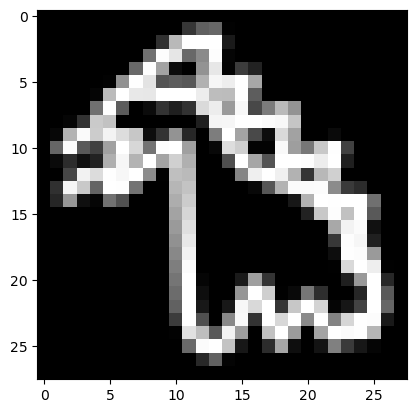

In [275]:
plt.imshow(data[np.random.choice(len(data))],cmap="gray")

In [276]:
Z_DIM = 128
EPOCHS = 5
LEARNING_RATE = 0.0001

In [277]:
from tensorflow.keras import layers,models,losses,optimizers,metrics

# Discriminator

In [278]:
inputs  = layers.Input(shape=(28, 28, 1))
x       = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
x       = layers.LeakyReLU(alpha=0.2)(x)
x       = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x       = layers.LeakyReLU(alpha=0.2)(x)
x       = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x       = layers.LeakyReLU(alpha=0.2)(x)
x       = layers.Flatten()(x)
x       = layers.Dropout(0.2)(x)
z       = layers.Dense(1, activation="sigmoid")(x)

discriminator = models.Model(inputs, z, name="discriminator")
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_78 (Conv2D)          (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_79 (Conv2D)          (None, 7, 7, 128)         131200    
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 conv2d_80 (Conv2D)          (None, 4, 4, 128)         262272    
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 4, 4, 128)       

# Generator

In [279]:
inputs  = layers.Input(shape=(Z_DIM,))
x       = layers.Dense(7 * 7 * 64)(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.UpSampling2D()(x)
x       = layers.Conv2D(128,  kernel_size=3, strides=1, padding='same', activation='relu')(x)
x       = layers.UpSampling2D()(x)
x       = layers.Conv2D(256,  kernel_size=3, strides=1, padding='same', activation='relu')(x)
outputs = layers.Conv2D(1,    kernel_size=5, strides=1, padding="same", activation="sigmoid")(x)

generator = models.Model(inputs, outputs, name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_27 (Dense)            (None, 3136)              404544    
                                                                 
 reshape_13 (Reshape)        (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d_26 (UpSampli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_81 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 up_sampling2d_27 (UpSampli  (None, 28, 28, 128)       0         
 ng2D)                                                   

# DCGAN Model

In [280]:
class DCGAN(models.Model):
    def __init__(self,my_discriminator,my_generator,z_dim=Z_DIM):
        super(DCGAN,self).__init__()
        
        self.discriminator = my_discriminator
        self.generator = my_generator
        self.z_dim = z_dim
        self.discriminator_opt = None
        self.generator_opt = None
        self.loss_fn = None
        self.g_loss = None
        self.d_loss = None
        
    def call(self, inputs, training=None, mask=None):
        # This method should handle both real and generated images
        return self.generator(inputs)
    
    def compile(self,d_opt,g_opt,loss_fn):
        super(DCGAN,self).compile()
        self.discriminator_opt = d_opt
        self.generator_opt = g_opt
        self.loss_fn = loss_fn
        self.discriminator.compile(optimizer=self.discriminator_opt,loss=self.loss_fn)
        self.generator.compile(optimizer=self.generator_opt,loss=self.loss_fn)
        self.d_loss = metrics.Mean(name="d_loss")
        self.g_loss = metrics.Mean(name="g_loss")
        
        
    @property
    def metrics(self):
        return [self.d_loss,self.g_loss]
    
    def train_step(self, real_imgs):
        batch_size = tf.shape(real_imgs)[0]
        sample_vector = tf.random.normal(shape=(batch_size, self.z_dim))
        
        with tf.GradientTape() as tape:
            generated_images = self.generator(sample_vector)
            concat_imgs = tf.concat([real_imgs, generated_images], axis=0)
            labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
            predictions = self.discriminator(concat_imgs)
            d_loss = self.loss_fn(labels, predictions)
            
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.discriminator_opt.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        sample_vector = tf.random.normal(shape=(batch_size, self.z_dim))
        false_labels = tf.ones((batch_size, 1))
        
        with tf.GradientTape() as tape:
            fake_imgs = self.generator(sample_vector)
            d_predictions = self.discriminator(fake_imgs)
            g_loss = self.loss_fn(false_labels, d_predictions)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.generator_opt.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        self.g_loss.update_state(g_loss)
        self.d_loss.update_state(d_loss)
        
        return {
            "d_loss": self.d_loss.result(),
            "g_loss": self.g_loss.result()
        }

In [281]:
dcgan = DCGAN(discriminator,generator)

In [282]:
d_opt = optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
g_opt = optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
loss_fn = losses.BinaryCrossentropy()

dcgan.compile(d_opt,g_opt,loss_fn)

In [283]:
dcgan.fit(data,batch_size=128,callbacks=ImageGenerator(10,Z_DIM,"callbacks"),epochs=EPOCHS)

Epoch 1/5
  2/972 [..............................] - ETA: 20:25 - d_loss: 0.6862 - g_loss: 0.7532

KeyboardInterrupt: 

# Generate new Images

In [ ]:
nb_img = 10

z = np.random.normal(size=(nb_img,Z_DIM,1))
print(z.shape)

predictions = dcgan.predict(z)

In [ ]:
predictions.shape

In [ ]:
plt.imshow(predictions[6],cmap="gray")

In [ ]:
dcgan.save("dcgan-qd-dragon.keras")